# **0. 준비**
나눔 폰트 설치, 구글 드라이브 연결, 필수 패키지 설치, 시각화 팔레트 확인

In [ ]:
# 나눔 폰트 설치 / 한글 깨짐 방지 , 런타임 다시 시작하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:
# factor_analyzer 라이브러리 설치
!pip install factor-analyzer

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!pip install shap
import shap

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
# 시각화에 사용할 팔레트 확인
plt.style.available

sns.color_palette("pastel")
sns.set(palette='pastel')

---

# **1. 사과 데이터 불러오기**

In [ ]:
# 제공받은 홍로 사과 데이터 불러오기
df = pd.read_excel("/home/work/.data/data/data.xlsx")

df_red = df[df['품종']=='홍로']
df_red

,조사일,과원이름,품종,시험수,과실번호,과중,종경,횡경,L/D 비,경도1,경도2,당도,산도,착색(L),착색(a),착색(b)
0,2015-09-07,김제,홍로,1,1,244.0,80.1,81.2,0.986453,36.246,43.666,14.0,0.232000,58.550,5.120,27.480
1,2015-09-07,김제,홍로,1,2,380.0,100.6,90.2,1.115299,43.423,30.485,13.2,0.206000,61.780,23.970,24.880
2,2015-09-07,김제,홍로,1,3,262.0,89.2,87.6,1.018265,36.949,40.532,14.3,0.184000,59.140,18.370,25.350
3,2015-09-07,김제,홍로,1,4,318.5,94.1,85.2,1.104460,36.838,36.821,14.3,0.204000,57.200,17.990,28.660
4,2015-09-07,김제,홍로,1,5,383.0,98.6,95.9,1.028154,28.420,33.037,15.2,0.204000,55.800,24.120,24.520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,2022-09-07,포천,홍로,3,6,241.0,71.7,82.2,0.872263,38.123,42.944,14.7,0.177014,27.880,32.870,9.205
1446,2022-09-07,포천,홍로,3,7,229.5,75.2,82.9,0.907117,39.374,31.725,13.0,0.233696,48.265,22.760,19.215
1447,2022-09-07,포천,홍로,3,8,256.0,72.1,88.5,0.814689,37.407,37.291,13.9,0.181704,36.440,31.635,14.050
1448,2022-09-07,포천,홍로,3,9,221.5,71.7,80.9,0.886279,44.921,38.049,15.9,0.218152,33.630,31.535,12.210


---

# **2. 사과 품질 칼럼 만들기**

target 데이터인 품질 칼럼을 생성하고 이를 예측한다.

품질은 1등급부터 4등급까지 나누며 등급별 기준은 논문 사실에 기재된 농촌진흥청 자료와 소비자 선호 기사를 바탕으로 한다.

* 등급별 기준

    - 과중: 320 / 250 / 215 / 그 미만

    - 당도: 14 / 14/ 12 / 그 미만

    - 당산비: 41 / 36 / 그 미만

In [ ]:
# 당산비 칼럼 생성
df_red['당산비'] = df_red['당도'] / df_red['산도']

In [ ]:
# 당도, 과중, 당산비 칼럼 null값 평균으로 채우기
mean_values = df_red[['당산비', '당도', '과중']].mean()
df_red[['당산비', '당도', '과중']] = df_red[['당산비', '당도', '과중']].fillna(mean_values)

In [ ]:
# '품질' 칼럼 초기화
df_red['품질'] = np.nan
df_red['품질'] = df_red['품질'].astype(str)

# 조건에 따라 '품질' 칼럼 값 설정
for index, row in df_red.iterrows():
    if row['당도']>=14 and row['과중']>=320 and row['당산비']>=41 :
        df_red.at[index, '품질'] = '1등급'
    elif row['당도']>=14 and row['과중']>=250 and row['당산비']>=36 :
        df_red.at[index, '품질'] = '2등급'
    elif row['당도']>=12 and row['과중']>=215:
        df_red.at[index, '품질'] = '3등급'
    else:
        df_red.at[index, '품질'] = '4등급'

In [ ]:
print('1등급 사과 수: ', len(df_red[df_red['품질']=='1등급']))
print('2등급 사과 수: ', len(df_red[df_red['품질']=='2등급']))
print('3등급 사과 수: ', len(df_red[df_red['품질']=='3등급']))
print('4등급 사과 수: ', len(df_red[df_red['품질']=='4등급']))

1등급 사과 수:  107
2등급 사과 수:  136
3등급 사과 수:  432
4등급 사과 수:  123


In [ ]:
df_red.head()

,조사일,과원이름,품종,시험수,과실번호,과중,종경,횡경,L/D 비,경도1,경도2,당도,산도,착색(L),착색(a),착색(b),당산비,품질
0,2015-09-07,김제,홍로,1,1,244.0,80.1,81.2,0.986453,36.246,43.666,14.0,0.232,58.55,5.12,27.48,60.344828,3등급
1,2015-09-07,김제,홍로,1,2,380.0,100.6,90.2,1.115299,43.423,30.485,13.2,0.206,61.78,23.97,24.88,64.077670,3등급
2,2015-09-07,김제,홍로,1,3,262.0,89.2,87.6,1.018265,36.949,40.532,14.3,0.184,59.14,18.37,25.35,77.717391,2등급
3,2015-09-07,김제,홍로,1,4,318.5,94.1,85.2,1.104460,36.838,36.821,14.3,0.204,57.20,17.99,28.66,70.098039,2등급
4,2015-09-07,김제,홍로,1,5,383.0,98.6,95.9,1.028154,28.420,33.037,15.2,0.204,55.80,24.12,24.52,74.509804,1등급


In [ ]:
# 요인분석 진행 후, weather 데이터와 합치기 위한 프레임
red_df_fa = df_red[['조사일', '과원이름', '품질']]
red_df_fa.reset_index(drop=True, inplace=True)
red_df_fa

,조사일,과원이름,품질
0,2015-09-07,김제,3등급
1,2015-09-07,김제,3등급
2,2015-09-07,김제,2등급
3,2015-09-07,김제,2등급
4,2015-09-07,김제,1등급
...,...,...,...
793,2022-09-07,포천,3등급
794,2022-09-07,포천,3등급
795,2022-09-07,포천,3등급
796,2022-09-07,포천,3등급


---

# **3. 요인분석용 기상데이터 만들기**


## 1) 기상 데이터 불러오기

 factor_weather
- 주어진 사과 재배 지역의 기상 데이터만으로는 요인 분석을 수행하기에 부족하기 때문에, 기상청에서 추가 데이터를 수집하였다.
- 이 파일에는 강원도 북춘천, 경상남도 전부, 경기도 전부, 전라북도 전부, 대구 전부, 충청북도 전부 (서청주 빼고)의 기상 데이터가 들어있다.

In [ ]:
# 요인분석을 위해 사용되는 지역들만 있으므로 변수 factor_weather라고 지정
factor_weather= pd.read_csv("/home/work/.data/data/factor_weather.csv",encoding='cp949')

import datetime
# 원래 날짜 형식과 변경할 날짜 형식 정의
date_formats = ["%y-%m", "%Y-%m"]

# 날짜 형식 변경 함수 정의
def convert_date(date_str):
    # '2016-10' 형식을 파싱하여 '16-10' 형식으로 변경
    year, month = date_str.split('-')
    return f'{year[2:]}-{month}'

# '일시' 열의 값을 변경하고 새로운 열에 저장
factor_weather['일시'] = factor_weather['일시'].apply(convert_date)

## 2) 데이터 프레임 형태 변환
- factor_weather은 지점과, 날짜에 해당하는 기상 데이터이므로 변환이 필요하다.
- 사과 품질 예측을 위해 조사일자로부터 **12개월의 모든 기상데이터가 하나의 데이터를 이루도록** 데이터프레임의 형태를 바꿔주었다.

In [ ]:
selected_columns = ['평균기온(°C)', '평균최고기온(°C)', '평균최저기온(°C)', '평균상대습도(%)',
                    '월합강수량(00~24h만)(mm)',  '평균풍속(m/s)', '최대풍속(m/s)',
                     '일조율(%)', '합계 일사량(MJ/m2)', '평균지면온도(°C)']

In [ ]:
# 처리할 지점들의 리스트
locations = factor_weather['지점명'].unique().tolist()

# 결과를 저장할 빈 리스트
df_result_list = []

# 빈 데이터프레임 생성
data = {'location': [], 'year': [], 'month': []}
location_df = pd.DataFrame(data)

# 각 지점에 대한 처리를 반복
for location in locations:

    # 해당 지점의 기상 데이터 추출
    location_weather = factor_weather[factor_weather['지점명'] == location].copy()
    location_weather.reset_index(drop=True, inplace=True)

    # '일시' 열을 기반으로 연도와 월을 분리
    location_weather['연도'] = location_weather['일시'].str.split('-').str[0].astype(int)
    location_weather['월'] = location_weather['일시'].str.split('-').str[1].astype(int)

    # 결과 데이터프레임 초기화
    weather_result = pd.DataFrame()

    # 연도별로 데이터를 처리
    for year in range(14, 23):
        year_df = location_weather[location_weather['연도'] == year]

        # 월별로 열을 재구성
        monthly_data = []

        for month in range(1, 13):
            month_data = year_df[year_df['월'] == month][selected_columns].mean()
            monthly_data.extend(month_data)

        # 결과 데이터프레임에 추가
        weather_result = weather_result.append(pd.Series(monthly_data, name=year))

    # 컬럼 이름 재구성
    new_columns = [f"{month}월 {col}" for month in range(1, 13) for col in selected_columns]
    weather_result.columns = new_columns

    # 연도 범위
    years = list(range(15, 23))

    # 월 목록
    months = [8, 9, 10]
    for year in years:
        for month in months:
            location_df = location_df.append({'location': location, 'year': year, 'month': month}, ignore_index=True)

# 처리할 지점들의 리스트
locations = factor_weather['지점명'].unique().tolist()
# 결과를 저장할 빈 리스트
df_result_list = []

# 빈 데이터프레임 생성
data = {'location': [], 'year': [], 'month': []}
location_df = pd.DataFrame(data)

# 각 지점에 대한 처리를 반복
for location in locations:

    # 해당 지점의 기상 데이터 추출
    location_weather = factor_weather[factor_weather['지점명'] == location].copy()
    location_weather.reset_index(drop=True, inplace=True)

    # '일시' 열을 기반으로 연도와 월을 분리
    location_weather['연도'] = location_weather['일시'].str.split('-').str[0].astype(int)
    location_weather['월'] = location_weather['일시'].str.split('-').str[1].astype(int)

    # 결과 데이터프레임 초기화
    weather_result = pd.DataFrame()

    # 연도별로 데이터를 처리
    for year in range(14, 23):
        year_df = location_weather[location_weather['연도'] == year]

        # 월별로 열을 재구성
        monthly_data = []

        for month in range(1, 13):
            month_data = year_df[year_df['월'] == month][selected_columns].mean()
            monthly_data.extend(month_data)

        # 결과 데이터프레임에 추가
        weather_result = weather_result.append(pd.Series(monthly_data, name=year))

    # 컬럼 이름 재구성
    new_columns = [f"{month}월 {col}" for month in range(1, 13) for col in selected_columns]
    weather_result.columns = new_columns

    # 연도 범위
    years = list(range(15, 23))

    # 월 목록
    months = [8, 9, 10]
    for year in years:
        for month in months:
            location_df = location_df.append({'location': location, 'year': year, 'month': month}, ignore_index=True)

    # 24 = 3개월*8년도
    for i in range(24):
        month = int(location_df['month'][i])
        year = int(location_df['year'][i])

        # '조사일' 전년도와 조사일년도 추출
        location_weather = weather_result.loc[[year - 1, year]]
        location_weather_flatten = location_weather.values.flatten()

        # condition = 사용할 기상데이터 종류
        condition = int(len(location_weather_flatten) / 12 / 2)

        data1 = location_weather_flatten[12 * condition:(condition * (12 + month))]
        data2 = location_weather_flatten[(condition * month):12 * condition]
        result = np.hstack((data1, data2))

        df_result = pd.DataFrame({
            '월': [month],
            '연도':[year],
            '지점명' : [location],
            **{f'{int(j/condition)+1}월 평균 기온(°C)': result[j] for j in range(0,12*condition, condition)},
            **{f'{int(j/condition)+1}월 평균 최고기온(°C)': result[j+1] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 평균 최저기온(°C)': result[j+2] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 평균 상대습도(%)': result[j+3] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 월합강수량(00~24h만)(mm)': result[j+4] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 평균풍속(m/s)': result[j+5] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 최대풍속(m/s)': result[j+6] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 일조율(%)': result[j+7] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 합계 일사량(MJ/m2)': result[j+8] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 평균지면온도(°C)': result[j+9] for j in range(0, 12*condition, condition)}
        }, index=[0])

        df_result_list.append(df_result)

# 모든 결과를 하나의 데이터프레임으로 병합
final_df_result = pd.concat(df_result_list, ignore_index=True)

final_df_result

,월,연도,지점명,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),...,3월 평균지면온도(°C),4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C)
0,8,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,16,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,16,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,9,21,남해,2.3,6.1,10.6,14.3,18.3,22.1,26.1,...,11.9,17.4,21.4,25.8,30.9,30.5,23.8,18.5,11.7,3.5
884,10,21,남해,2.3,6.1,10.6,14.3,18.3,22.1,26.1,...,11.9,17.4,21.4,25.8,30.9,30.5,23.8,18.8,11.7,3.5
885,8,22,남해,2.4,2.8,9.7,14.9,19.1,22.3,26.4,...,11.7,18.6,25.8,26.6,29.3,28.5,23.8,18.8,10.7,4.7
886,9,22,남해,2.4,2.8,9.7,14.9,19.1,22.3,26.4,...,11.7,18.6,25.8,26.6,29.3,28.5,25.2,18.8,10.7,4.7


In [ ]:
weather_df_result = final_df_result.copy()

# 연도, 월, 과원이름 묶어서 index로 만들기
weather_df_result.set_index(['월', '연도', '지점명'], inplace=True)

# weather_df_result.to_excel('apple_weather.xlsx', index=False)
weather_df_result

1월 평균 기온(°C)  2월 평균 기온(°C)  3월 평균 기온(°C)  4월 평균 기온(°C)  \
월  연도 지점명                                                           
8  15 북춘천           NaN           NaN           NaN           NaN   
9  15 북춘천           NaN           NaN           NaN           NaN   
10 15 북춘천           NaN           NaN           NaN           NaN   
8  16 북춘천           NaN           NaN           NaN           NaN   
9  16 북춘천           NaN           NaN           NaN           NaN   
...                 ...           ...           ...           ...   
   21 남해            2.3           6.1          10.6          14.3   
10 21 남해            2.3           6.1          10.6          14.3   
8  22 남해            2.4           2.8           9.7          14.9   
9  22 남해            2.4           2.8           9.7          14.9   
10 22 남해            2.4           2.8           9.7          14.9   

           5월 평균 기온(°C)  6월 평균 기온(°C)  7월 평균 기온(°C)  8월 평균 기온(°C)  \
월  연도 지점명                                                           
8  15 북춘천           NaN           NaN           NaN           NaN   
9  15 북춘천           NaN           NaN           NaN           NaN   
10 15 북춘천           NaN           NaN           NaN           NaN   
8  16 북춘천           NaN           NaN           NaN           NaN   
9  16 북춘천           NaN           NaN           NaN           NaN   
...                 ...           ...           ...           ...   
   21 남해           18.3          22.1          26.1          26.1   
10 21 남해           18.3          22.1          26.1          26.1   
8  22 남해           19.1          22.3          26.4          26.3   
9  22 남해           19.1          22.3          26.4          26.3   
10 22 남해           19.1          22.3          26.4          26.3   

           9월 평균 기온(°C)  10월 평균 기온(°C)  ...  3월 평균지면온도(°C)  4월 평균지면온도(°C)  \
월  연도 지점명                               ...                                 
8  15 북춘천           NaN            NaN  ...            NaN            NaN   
9  15 북춘천           NaN            NaN  ...            NaN            NaN   
10 15 북춘천           NaN            NaN  ...            NaN            NaN   
8  16 북춘천           NaN            NaN  ...            NaN            NaN   
9  16 북춘천           NaN            NaN  ...            NaN            NaN   
...                 ...            ...  ...            ...            ...   
   21 남해           22.2           15.9  ...           11.9           17.4   
10 21 남해           22.2           17.2  ...           11.9           17.4   
8  22 남해           22.2           17.2  ...           11.7           18.6   
9  22 남해           22.1           17.2  ...           11.7           18.6   
10 22 남해           22.1           16.3  ...           11.7           18.6   

           5월 평균지면온도(°C)  6월 평균지면온도(°C)  7월 평균지면온도(°C)  8월 평균지면온도(°C)  \
월  연도 지점명                                                               
8  15 북춘천            NaN            NaN            NaN            NaN   
9  15 북춘천            NaN            NaN            NaN            NaN   
10 15 북춘천            NaN            NaN            NaN            NaN   
8  16 북춘천            NaN            NaN            NaN            NaN   
9  16 북춘천            NaN            NaN            NaN            NaN   
...                  ...            ...            ...            ...   
   21 남해            21.4           25.8           30.9           30.5   
10 21 남해            21.4           25.8           30.9           30.5   
8  22 남해            25.8           26.6           29.3           28.5   
9  22 남해            25.8           26.6           29.3           28.5   
10 22 남해            25.8           26.6           29.3           28.5   

           9월 평균지면온도(°C)  10월 평균지면온도(°C)  11월 평균지면온도(°C)  12월 평균지면온도(°C)  
월  연도 지점명                                                                 
8  15 북춘천            NaN             NaN             NaN             NaN  
9  15 북춘천            NaN             N

---

# **4. 요인분석**
아래의 요인 분석의 결과 요약
- 적합성 검정을 통해 데이터가 요인분석을 하기에 적절한 데이터임을 확인하였다
- 요인 수를 14로 설정하였다.
- 요인분석의 결과를 보고 새로운 변수 14개를 만들기로 결정하였다.




### 0. 데이터 전처리

In [ ]:
# 변수 스케일링
from sklearn.preprocessing import StandardScaler

# 스케일링할 연속형 변수를 선택
continuous_columns = weather_df_result.columns

# StandardScaler 객체 생성
scaler = StandardScaler()
weather_df_result[continuous_columns] = scaler.fit_transform(weather_df_result[continuous_columns])

In [ ]:
# 결측치를 평균값으로 대체
weather_df_result = weather_df_result.fillna(weather_df_result.mean())

### 1) 적합성 검정

- 요인 분석을 수행하기 전에 데이터 세트의 “인자 가능성”을 평가해야 한다.
- 요인 분석 가능성은 “데이터 세트에서 요인을 찾을 수 있는가?”를 의미한다.

(1) Bartlett검정

구면성 검정에서는 관측된 상관 행렬을 사용하여 관측된 변수가 단위 행렬과 상호 관련되는지 여부를 확인한다.
* 유의수준을 기준으로 **p값이 0.05 이하**면 요인 분석을 수행해도 괜찮은 정도의 상관관계가 존재한다고 판단한다.

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value,p_value=calculate_bartlett_sphericity(weather_df_result)

chi_square_value, p_value

(229021.59666423925, 0.0)

(2) KMO(Kaiser-Meyer-Olkin)

KMO값은 표본 적합도를 나타내는 값
* 일반적으로 **0.5 이상**이면 자료가 요인분석에 적절하다고 판단한다.

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all,kmo_model=calculate_kmo(weather_df_result)

kmo_model

0.8724184886324915

=> 적합성 검정의 결과
 - Bartlett검정의 결과 p값이 0.5 이하이고, KMO 값이 0.5이상이므로 요인 분석을 수행해도 된다.

### 2) 요인 수 선택

요인 수를 선택하는 데 카이저 기준과 스크리 플랏을 사용할 수 있다. 둘 다 고유값을 기반으로 한다.

* 카이저 기준 : 1보다 큰 고유값을 가지는 요인을 선택하는 것을 제안

* 스크리 플랏 : 고유값이 급격하게 감소하는 지점을 '굴곡점' 또는 '깁스 팔꿈치'라고 부르며, 이 지점 이전까지의 요인을 선택

In [ ]:
# 카이저 기준
from factor_analyzer import FactorAnalyzer

# 요인 분석 객체 생성
# method='ml' : 최대우도추정법, method='principal' : 주성분분석
fa = FactorAnalyzer(n_factors=15, method='principal', rotation=None)

# 요인 분석 수행
fa.fit(weather_df_result)

# 고유값(eigenvalues) 출력
ev, v = fa.get_eigenvalues()
selected_factors = sum(ev > 1)
selected_factors # => 18개의 요인

18

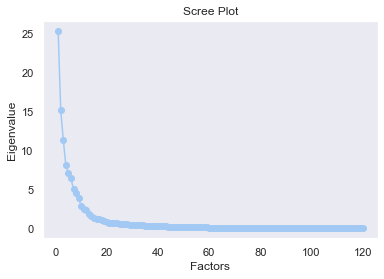

In [ ]:
# 시각화
plt.scatter(range(1,weather_df_result.shape[1]+1),ev)
plt.plot(range(1,weather_df_result.shape[1]+1),ev)

plt.title("Scree Plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
plt.grid()

plt.show()

=> y축 값의 크기가 1 이상인가로 판단한다. 위의 카이저 기준과 비슷하게 대략 18정도임을 직관적으로 확인할 수 있다.

### 3) 요인분석 수행 + 회전시키기

요인 방법의 회전 방법에는 직각회전과 비직각회전이 있으며, 직각 회전은 요인간에 상관이 없을 때, 비직각회전은 요인간에 상관이 있을 때 사용한다.

* SS Loadings (Sum of Squares Loadings): 각 요인이 설명하는 분산의 합계로, 이 값이 높을수록 해당 요인들이 데이터의 변동성을 많이 설명한다.

* Proportion Variance: 각 요인이 설명하는 분산의 비율로, 전체 분산 대비 해당 요인의 비중을 나타낸다.

* Cumulative Variance: 누적 분산 비율로, 첫 번째 요인부터 순차적으로 더해가며 누적된 분산의 비율을 표시한다. 이를 통해 몇 개의 요인을 선택할지 결정하는 데 도움이 된다.

=> 일반적으로 누적 기여율이 85% 정도가 되는 부분까지만 주성분을 사용한다.

(0) 회전시키지 않고 요인분석 수행

요인 분석을 할 때 유의해야할 점은 요인 회전을 통해서 해석력이 좋은 요인 적재량 행렬을 항상 얻을 수 있는 것은 아니며, 가능성이 있는 것이다.

In [ ]:
# 요인 분석 수행
fa_none = FactorAnalyzer(n_factors=18, rotation=None)
fa_none.fit(weather_df_result)

# 요인 로딩 추출
loadings = fa_none.loadings_
loadings_df = pd.DataFrame(loadings, index=weather_df_result.columns, columns=[f'Factor{i}' for i in range(1, 19)])
loadings_df

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18
1월 평균 기온(°C),0.826243,-0.013628,-0.426045,-0.021699,0.229877,-0.009727,-0.122943,-0.044444,0.037581,-0.009136,0.110125,-0.100436,-0.011184,-0.115781,0.034457,0.083349,0.041832,0.058561
2월 평균 기온(°C),0.810448,-0.067844,-0.388844,0.062778,0.029054,-0.024021,-0.197460,0.099051,0.041687,-0.094272,-0.038576,-0.182234,0.232609,0.034484,0.083018,0.010377,0.026469,0.039145
3월 평균 기온(°C),0.758529,-0.302415,-0.040284,0.444156,-0.139816,-0.118759,-0.087907,0.060904,-0.055005,-0.121307,0.017660,0.106265,0.068821,-0.029421,0.044197,0.013496,0.108094,0.006631
4월 평균 기온(°C),0.501831,-0.485269,0.551578,-0.031657,-0.137184,0.251579,0.084909,-0.033330,0.015358,-0.120426,-0.136483,-0.139304,0.012903,-0.006584,0.008820,0.068048,0.111604,-0.027016
5월 평균 기온(°C),0.570872,-0.455023,0.198788,-0.366670,0.329144,-0.048112,-0.016449,0.052091,0.077462,-0.044074,0.192486,0.117802,-0.053659,-0.072231,-0.026492,0.025887,0.120107,0.127950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8월 평균지면온도(°C),0.368654,-0.180301,0.192948,-0.180066,-0.368513,-0.217552,0.148425,0.391467,0.295749,0.058371,0.212835,0.262091,-0.183826,0.039326,0.105674,-0.096459,-0.039961,-0.014841
9월 평균지면온도(°C),0.545024,-0.233612,0.141406,-0.143597,0.059278,0.176851,0.143495,-0.093879,-0.193482,0.026309,0.213290,-0.038773,0.046632,0.192564,0.036816,-0.318548,-0.052902,-0.086737
10월 평균지면온도(°C),0.752961,-0.247440,-0.027465,0.024154,0.051632,0.114762,0.126092,-0.055924,-0.014585,-0.044296,0.057380,-0.232983,-0.194028,-0.002069,-0.020060,-0.188512,-0.130616,-0.081918
11월 평균지면온도(°C),0.832949,-0.094816,-0.140036,-0.180246,-0.146495,0.225560,-0.041927,0.132375,-0.107338,-0.107030,-0.074816,-0.038993,-0.100163,0.062926,0.111589,-0.052809,-0.073428,-0.051599


In [ ]:
# (1) 요인 분산 정보 가져오기
factor_variance0 = fa_none.get_factor_variance()

# 요인 분산 정보를 데이터프레임으로 변환
factor_variance_df0 = pd.DataFrame(factor_variance0, index=["SS Loadings", "Proportion Variance", "Cumulative Variance"]).T
factor_variance_df0

,SS Loadings,Proportion Variance,Cumulative Variance
0,25.294833,0.210790,0.210790
1,15.002270,0.125019,0.335809
2,11.249897,0.093749,0.429558
3,7.968562,0.066405,0.495963
4,6.916661,0.057639,0.553602
5,6.230992,0.051925,0.605527
6,4.929358,0.041078,0.646605
7,4.247262,0.035394,0.681999
8,3.659585,0.030497,0.712495
9,2.742381,0.022853,0.735348


(1) 요인의 수를 18개로 회전시키기

In [ ]:
# 요인 분석 수행
fa_varimax  = FactorAnalyzer(n_factors=18, rotation="promax")
fa_varimax.fit(weather_df_result)

# 요인 로딩 추출
loadings1 = fa_varimax.loadings_
loadings_df1 = pd.DataFrame(loadings1, index=weather_df_result.columns, columns=[f'Factor{i}' for i in range(1, 19)])
loadings_df1

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18
1월 평균 기온(°C),0.993849,0.039926,-0.223646,0.161420,-0.068854,-0.019762,-0.077135,-0.004391,0.203300,0.099305,0.008878,0.006826,-0.037006,0.019272,0.008154,-0.064768,0.077594,-0.135108
2월 평균 기온(°C),1.037036,-0.027077,-0.019060,-0.179637,-0.027788,-0.085398,-0.157639,-0.011620,0.125083,0.019417,0.084820,0.237159,0.092001,-0.117934,-0.058927,0.045483,-0.045439,-0.026197
3월 평균 기온(°C),0.633710,-0.011830,0.234823,-0.152757,0.138063,0.123013,0.080393,0.005020,0.130822,0.021583,0.244351,-0.165736,0.091761,-0.146189,-0.039532,0.006184,-0.063248,-0.146824
4월 평균 기온(°C),0.455984,0.049748,0.783386,0.072361,0.051445,-0.020754,-0.092626,0.019542,-0.034575,-0.087130,-0.089756,0.011203,0.190903,0.085732,-0.053889,0.040598,-0.131326,-0.059419
5월 평균 기온(°C),0.388831,0.022864,0.032341,0.549066,0.084083,0.083517,0.309944,-0.001176,0.000877,-0.066016,0.005633,0.065864,0.005165,0.050149,0.200190,0.026508,-0.047465,-0.328372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8월 평균지면온도(°C),-0.045517,-0.035341,0.114600,-0.069646,0.048073,-0.034621,0.905700,0.046649,-0.002707,-0.056139,-0.009446,-0.065524,0.011359,-0.039182,0.348564,-0.099021,-0.027278,0.003290
9월 평균지면온도(°C),0.394919,-0.055605,0.065640,0.148409,0.063498,-0.011539,-0.027727,0.009548,-0.140988,-0.039584,-0.031770,0.063758,-0.011058,-0.038627,0.419604,0.458716,-0.086602,0.060238
10월 평균지면온도(°C),0.774997,-0.012471,0.038445,-0.033663,0.067422,0.019347,-0.098700,0.003011,0.010305,-0.112504,-0.262165,0.007358,0.055568,0.021811,0.330259,0.140784,0.175161,0.050467
11월 평균지면온도(°C),0.905338,-0.011617,0.014190,-0.013380,-0.081263,-0.167043,0.047500,-0.013369,-0.251183,-0.104678,0.111340,0.037290,0.066684,-0.005769,0.124182,-0.007605,-0.028256,0.094605


In [ ]:
# (1) 요인 분산 정보 가져오기
factor_variance1 = fa_varimax.get_factor_variance()

# 요인 분산 정보를 데이터프레임으로 변환
factor_variance_df1 = pd.DataFrame(factor_variance1, index=["SS Loadings", "Proportion Variance", "Cumulative Variance"]).T
factor_variance_df1

,SS Loadings,Proportion Variance,Cumulative Variance
0,21.256157,0.177135,0.177135
1,14.696367,0.122470,0.299604
2,9.731460,0.081095,0.380700
3,6.128265,0.051069,0.431769
4,5.815561,0.048463,0.480232
5,5.568860,0.046407,0.526639
6,5.397015,0.044975,0.571614
7,5.294673,0.044122,0.615736
8,4.443399,0.037028,0.652765
9,4.407303,0.036728,0.689492


=> Cumulative Variance를 보았을 때 회전한 후에 성능이 더 높다. 대부분의 경우에 회전시켜야 성능이 더 높게 나온다.

=> 일반적으로 자연과학에서는 누적 기여율이 80% 정도만 넘으면 된다. 따라서, 변수의 수를 더 줄이고자 요인의 수를 14개로 축소하겠다.

(2) 요인의 수를 14개로 회전시키기

In [ ]:
# 요인 분석 수행
fa_none2  = FactorAnalyzer(n_factors=14, rotation="promax")
fa_none2.fit(weather_df_result)

# 요인 로딩 추출
loadings2 = fa_none2.loadings_
loadings_df2 = pd.DataFrame(loadings2, index=weather_df_result.columns, columns=[f'Factor{i}' for i in range(1, 15)])
loadings_df2

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14
1월 평균 기온(°C),0.948820,0.061449,-0.326897,-0.115266,0.030970,0.154254,-0.015920,-0.089751,0.012814,0.089130,-0.002835,-0.066395,0.020110,-0.141294
2월 평균 기온(°C),0.962003,-0.009917,-0.088884,0.227278,-0.026234,0.116446,-0.058922,-0.149120,-0.004630,0.002909,-0.335931,-0.173087,0.227046,-0.137033
3월 평균 기온(°C),0.615864,-0.009827,0.206511,0.185272,-0.051965,0.222512,0.100856,0.103727,0.016148,-0.268262,0.127034,-0.245858,0.092929,-0.012589
4월 평균 기온(°C),0.492943,0.046282,0.782926,-0.054291,-0.160822,-0.052025,-0.017012,-0.070045,0.010758,0.122350,-0.136401,-0.021977,0.023796,0.096640
5월 평균 기온(°C),0.452556,0.018564,0.005992,-0.555140,-0.274618,0.068811,0.217885,0.344664,0.015317,0.056195,0.022166,0.022468,0.037229,-0.033380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8월 평균지면온도(°C),-0.057605,-0.015274,0.130515,0.067710,0.041178,-0.010373,0.139690,0.945481,0.053198,0.033759,0.155637,0.035955,-0.153291,0.034308
9월 평균지면온도(°C),0.538548,-0.076605,0.218957,-0.224915,0.098141,-0.023315,0.066315,0.027311,0.009540,-0.147570,-0.071430,0.249532,0.320852,0.060932
10월 평균지면온도(°C),0.881072,-0.023397,0.154855,-0.029419,0.014147,0.106435,0.040478,-0.095738,0.009046,0.098957,-0.016547,0.220090,-0.082181,0.071877
11월 평균지면온도(°C),0.866613,0.012909,-0.011673,0.022667,-0.044832,-0.241472,-0.151380,0.058306,-0.015158,-0.105411,-0.091716,0.031893,-0.062309,-0.014162


In [ ]:
plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지

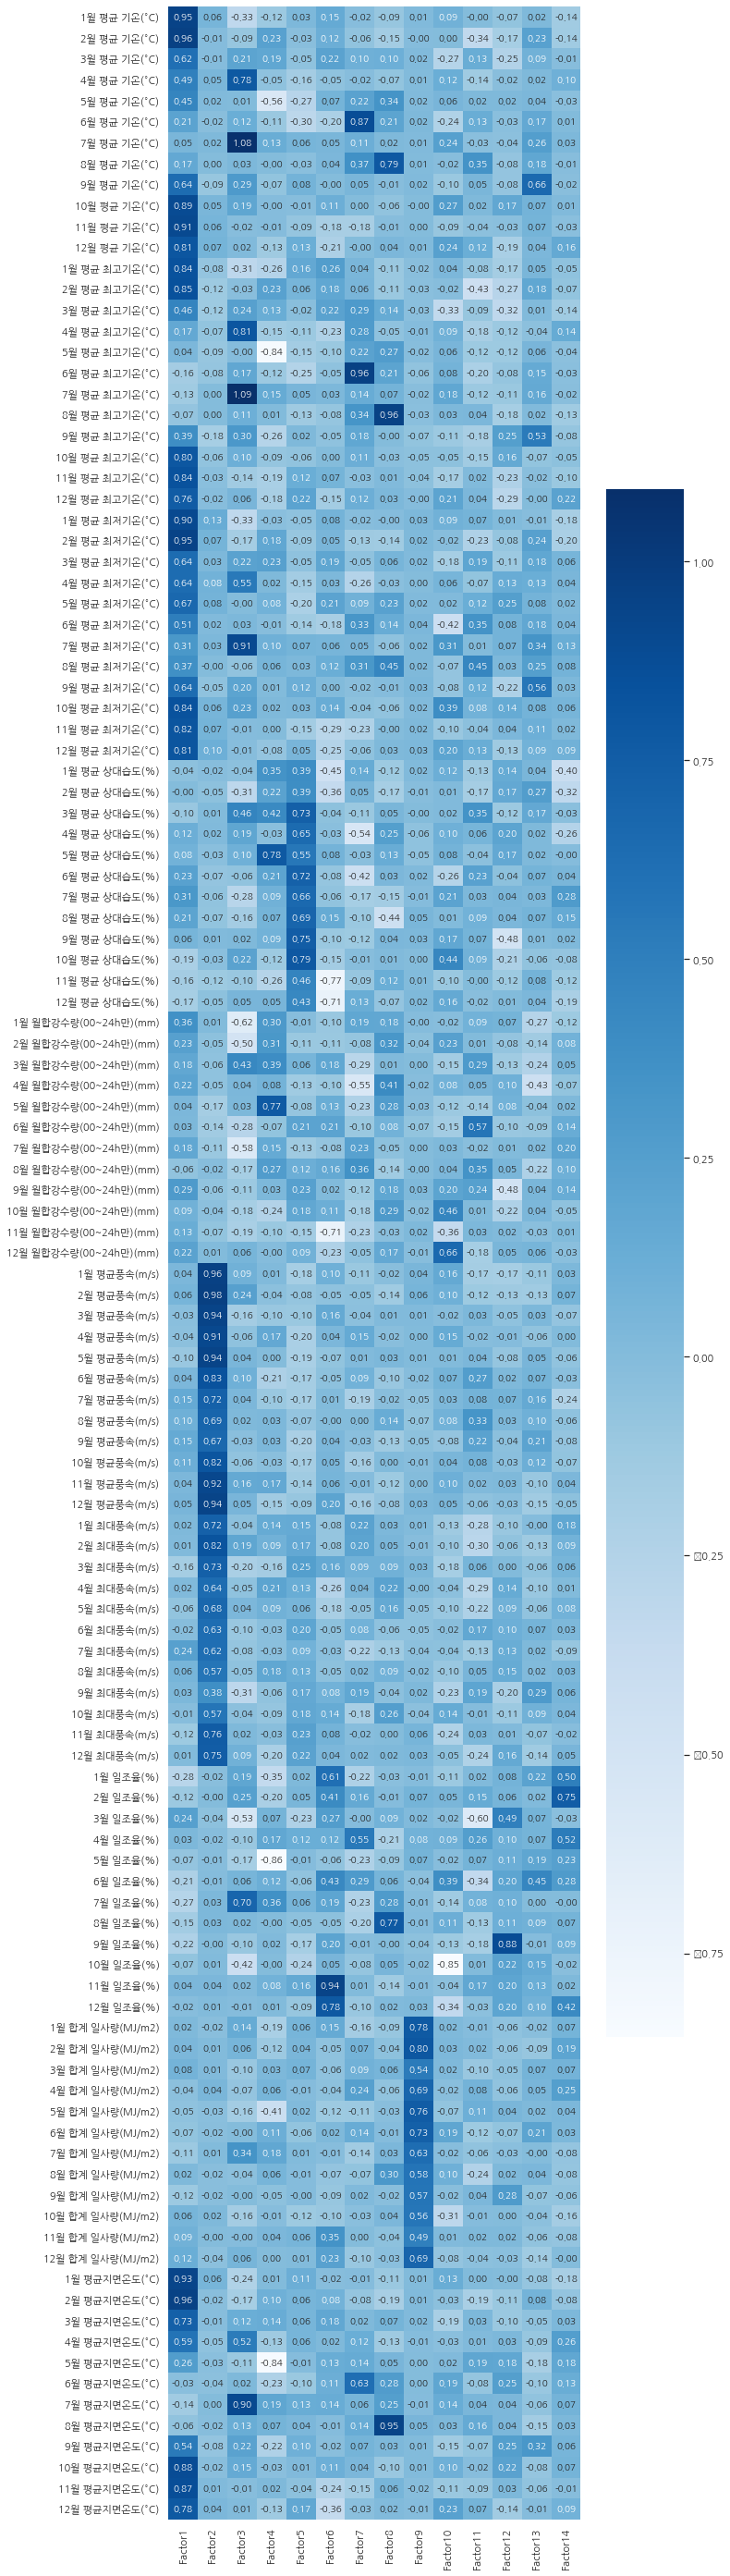

In [ ]:
# (0) loadings의 시각화
plt.figure(figsize=(10,50))
sns.heatmap(loadings_df2, cmap="Blues", annot=True, fmt='.2f')
plt.show()

In [ ]:
# 각 요인의 주요 변수 살펴보기
for i in range(14):
    sorted_loadings = loadings_df2.iloc[:, i].abs().sort_values(ascending=False)
    print('factor', i+1)
    col = f'Factor{i+1}'
    print(loadings_df2.loc[sorted_loadings.index, col][:10])
    print(loadings_df2.loc[sorted_loadings.index, col][:10].index)
    print('            ')

factor 1
2월 평균 기온(°C)      0.962003
2월 평균지면온도(°C)     0.959436
1월 평균 기온(°C)      0.948820
2월 평균 최저기온(°C)    0.947361
1월 평균지면온도(°C)     0.933774
11월 평균 기온(°C)     0.906648
1월 평균 최저기온(°C)    0.904624
10월 평균 기온(°C)     0.890222
10월 평균지면온도(°C)    0.881072
11월 평균지면온도(°C)    0.866613
Name: Factor1, dtype: float64
Index(['2월 평균 기온(°C)', '2월 평균지면온도(°C)', '1월 평균 기온(°C)', '2월 평균 최저기온(°C)',
       '1월 평균지면온도(°C)', '11월 평균 기온(°C)', '1월 평균 최저기온(°C)', '10월 평균 기온(°C)',
       '10월 평균지면온도(°C)', '11월 평균지면온도(°C)'],
      dtype='object')
            
factor 2
2월 평균풍속(m/s)     0.976242
1월 평균풍속(m/s)     0.963665
3월 평균풍속(m/s)     0.944444
5월 평균풍속(m/s)     0.942659
12월 평균풍속(m/s)    0.939017
11월 평균풍속(m/s)    0.916366
4월 평균풍속(m/s)     0.913352
6월 평균풍속(m/s)     0.832632
2월 최대풍속(m/s)     0.823923
10월 평균풍속(m/s)    0.817214
Name: Factor2, dtype: float64
Index(['2월 평균풍속(m/s)', '1월 평균풍속(m/s)', '3월 평균풍속(m/s)', '5월 평균풍속(m/s)',
       '12월 평균풍속(m/s)', '11월 평균풍속(m/s)', '4월 평균풍속(m/s)', '6월 평균풍속(m/s)',
       '2월 최대풍속(m/s

=> 요인분석의 결과를 보고 각 요인의 주요 변수를 살펴보고 공통점을 찾아 요인 명칭을 정해 모델링을 위한 데이터 프레임을 만들도록 하겠다.

### **요인 분석에 따른 새로운 변수 생성**

1. 1,2월 온도 (top5개)
    
    -> '2월 평균 기온(°C)', '2월 평균지면온도(°C)', '1월 평균 기온(°C)', '2월 평균 최저기온(°C)','1월 평균지면온도(°C)'

2. 평균풍속 (top 7개, 0.9 이상인 값들)
    
    -> '2월 평균풍속(m/s)', '1월 평균풍속(m/s)', '3월 평균풍속(m/s)', '5월 평균풍속(m/s)', '12월 평균풍속(m/s)', '11월 평균풍속(m/s)', '4월 평균풍속(m/s)'

3. 7월의 기온 (top 4개, 0.9 이상인 값들)

    -> '7월 평균 최고기온(°C)', '7월 평균 기온(°C)', '7월 평균 최저기온(°C)', '7월 평균지면온도(°C)'


4. 5월의 온도 (top 3개, 절댓값 0.8 이상)

    -> '5월 일조율(%)', '5월 평균지면온도(°C)', '5월 평균 최고기온(°C)'


5. 평균 상대습도 (top 8개, 0.5 이상)

    -> '10월 평균 상대습도(%)', '9월 평균 상대습도(%)', '3월 평균 상대습도(%)', '6월 평균 상대습도(%)','8월 평균 상대습도(%)', '7월 평균 상대습도(%)', '4월 평균 상대습도(%)', '5월 평균 상대습도(%)'

6. 11월,12월 일조율 (top 2개)
    
    -> '11월 일조율(%)', '12월 일조율(%)'


7. 6월 기온 (top 3개, 양수값들)

    -> '6월 평균 최고기온(°C)', '6월 평균 기온(°C)', '6월 평균지면온도(°C)'

8. 8월 온도 (top 4)

    -> '8월 평균 최고기온(°C)', '8월 평균지면온도(°C)', '8월 평균 기온(°C)', '8월 일조율(%)'


9. 합계일사량 (top 10개)

    -> '2월 합계 일사량(MJ/m2)', '1월 합계 일사량(MJ/m2)', '5월 합계 일사량(MJ/m2)','6월 합계 일사량(MJ/m2)',  '12월 합계 일사량(MJ/m2)', '4월 합계 일사량(MJ/m2)','7월 합계 일사량(MJ/m2)', '8월 합계 일사량(MJ/m2)',  '9월 합계 일사량(MJ/m2)','10월 합계 일사량(MJ/m2)','3월 합계 일사량(MJ/m2)', '11월 합계 일사량(MJ/m2)'


10. 10,12월 월합강수량 (2,3등)

    -> '12월 월합강수량(00~ 24h만)(mm)', '10월 월합강수량(00~24h만)(mm)'

11. 기타 (top 4개, 절댓값 0.4이상)
    
    -> '3월 일조율(%)', '6월 월합강수량(00~24h만)(mm)', '8월 평균 최저기온(°C)','2월 평균 최고기온(°C)'


12. 9월 일조율 (top1개)

    -> '9월 일조율(%)'

13. 9월 온도 (top3개, 0.5이상)

    -> '9월 평균 기온(°C)', '9월 평균 최저기온(°C)', '9월 평균 최고기온(°C)'

14. 12,1,2,4월 일조율 (top4개, 0.4이상)

    -> '2월 일조율(%)', '4월 일조율(%)', '1월 일조율(%)', '12월 일조율(%)'

In [ ]:
# (1) 요인 분산 정보 가져오기
## 사회과학에서는 60%, 자연과학에서는 80% 이상의 누적 분산을 가지도록 해야한다.
factor_variance2 = fa_none2.get_factor_variance()

# 요인 분산 정보를 데이터프레임으로 변환
factor_variance_df2 = pd.DataFrame(factor_variance2, index=["SS Loadings", "Proportion Variance", "Cumulative Variance"]).T
factor_variance_df2

,SS Loadings,Proportion Variance,Cumulative Variance
0,21.706149,0.180885,0.180885
1,14.678795,0.122323,0.303208
2,10.457811,0.087148,0.390356
3,6.442627,0.053689,0.444045
4,6.382355,0.053186,0.497231
5,6.253896,0.052116,0.549347
6,5.709281,0.047577,0.596924
7,5.420614,0.045172,0.642096
8,5.305915,0.044216,0.686312
9,4.220000,0.035167,0.721479


In [ ]:
# (2) 공통성 구하기 - 각 변수의 요인 적재값의 제곱합 의미 , 각 변수로부터 추출된 요인에 의해 설명되는 비율
## 보통 0.5 이상이면 충분한 공통성을 가진다고 판단한다.
pd.DataFrame(fa_none2.get_communalities(), index=weather_df_result.columns)

,0
1월 평균 기온(°C),1.090139
2월 평균 기온(°C),1.238228
3월 평균 기온(°C),0.687104
4월 평균 기온(°C),0.938901
5월 평균 기온(°C),0.766674
...,...
8월 평균지면온도(°C),0.994581
9월 평균지면온도(°C),0.605645
10월 평균지면온도(°C),0.894521
11월 평균지면온도(°C),0.863322


=> 83%의 누적 분산을 가지고, 충분한 공통성을 가지므로 14개의 요인을 사용하는 것은 적절하다.


---

# **5. 모델링을 위한 데이터 프레임 만들기**
- 품질과 조사일, 그리고 수확일을 기준으로 12개월 전의 모든 기상 데이터가 한 행을 이루도록 한다.
- 조사일의 '일'이 15 이하이면 해당 월을 기상 데이터를 포함하지 않고, 15 초과이면 해당 월의 기상 데이터를 포함하도록 한다.

    ex) 2020년 9월 10일 수확 -> 2019년 9월 ~ 2020년 8월의 기상 데이터

    2020년 9월 24일 수확 -> 2019년 10월 ~ 2020년 9월의 기상 데이터

In [ ]:
red_df_fa

,조사일,과원이름,품질
0,2015-09-07,김제,3등급
1,2015-09-07,김제,3등급
2,2015-09-07,김제,2등급
3,2015-09-07,김제,2등급
4,2015-09-07,김제,1등급
...,...,...,...
793,2022-09-07,포천,3등급
794,2022-09-07,포천,3등급
795,2022-09-07,포천,3등급
796,2022-09-07,포천,3등급


<참고>

- 화성 -> 경기도 수원시
- 포천 -> 경기도 동두천
- 김제 -> 전북 전주 ( 군산이랑 비교시 거리가 비교적 가까움 )
- 완주 -> 전북 전주
- 남해 -> 경상남도 남해
- 충주 3개 -> 충청북도 충주
- 춘천 -> 강원도 북춘천
- 군위 -> 대구


In [ ]:
# 홍로 프레임에 '기상지점' 칼럼 추가
# 각 과원에서 가장 가까운 기상 관측지점으로 추가하였다.
red_df_fa['기상지점'] = red_df_fa['과원이름'].map({
    '화성': '수원',
    '포천': '동두천',
    '김제': '전주',
    '완주': '전주',
    '남해': '남해',
    '충주': '충주',
    '춘천': '북춘천',
    '군위': '대구'
})

red_df_fa

,조사일,과원이름,품질,기상지점
0,2015-09-07,김제,3등급,전주
1,2015-09-07,김제,3등급,전주
2,2015-09-07,김제,2등급,전주
3,2015-09-07,김제,2등급,전주
4,2015-09-07,김제,1등급,전주
...,...,...,...,...
793,2022-09-07,포천,3등급,동두천
794,2022-09-07,포천,3등급,동두천
795,2022-09-07,포천,3등급,동두천
796,2022-09-07,포천,3등급,동두천


In [ ]:
final_df_result

,월,연도,지점명,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),...,3월 평균지면온도(°C),4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C)
0,8,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,16,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,16,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,9,21,남해,2.3,6.1,10.6,14.3,18.3,22.1,26.1,...,11.9,17.4,21.4,25.8,30.9,30.5,23.8,18.5,11.7,3.5
884,10,21,남해,2.3,6.1,10.6,14.3,18.3,22.1,26.1,...,11.9,17.4,21.4,25.8,30.9,30.5,23.8,18.8,11.7,3.5
885,8,22,남해,2.4,2.8,9.7,14.9,19.1,22.3,26.4,...,11.7,18.6,25.8,26.6,29.3,28.5,23.8,18.8,10.7,4.7
886,9,22,남해,2.4,2.8,9.7,14.9,19.1,22.3,26.4,...,11.7,18.6,25.8,26.6,29.3,28.5,25.2,18.8,10.7,4.7


In [ ]:
# 처리할 지점들의 리스트
locations = ['전주', '북춘천', '동두천', '수원', '충주', '대구', '남해']

# 결과를 저장할 빈 리스트
df_result_list = []

# 각 지점에 대한 처리를 반복
for location in locations:

    # 해당 지점의 기상 데이터 추출
    location_weather = final_df_result[final_df_result['지점명'] == location]
    location_weather.reset_index(drop=True, inplace=True)

    #해당 지점 (타겟이 있는) 데이터프레임 추출
    location_df = red_df_fa[red_df_fa['기상지점'] == location]
    location_df['조사일'] = pd.to_datetime(location_df['조사일'])  # 데이트타임으로 변환
    location_df.drop('기상지점', axis=1, inplace=True)
    location_df.reset_index(drop=True, inplace=True)  # 인덱스 초기화

    n = len(location_df)

    for i in range(n):
        year = int(str(location_df['조사일'][i])[2:4])
        month = int(str(location_df['조사일'][i])[5:7])
        day = int(str(location_df['조사일'][i])[8:10])

        #15일 전에는 '조사일'에 해당하는 월 제외
        if day <= 15:
          month = month - 1
        else:
          month = month

        data1 = pd.DataFrame(location_df.iloc[i]).T  # data1을 데이터프레임으로 변환
        data1.reset_index(drop=True, inplace=True)
        data2 = location_weather[(location_weather['월'] == month) & (location_weather['연도'] == year)]
        data2.drop(['월', '연도', '지점명'], axis=1, inplace=True)
        data2 = data2.iloc[0:1]  # 하나의 행만 선택하여 데이터프레임으로 변환
        data2.reset_index(drop=True, inplace=True)

        # 두 데이터프레임을 합치기 (concatenate)
        df_result = pd.concat([data1, data2], axis=1)
        df_result_list.append(df_result)

# 모든 결과를 하나의 데이터프레임으로 병합
result = pd.concat(df_result_list)
result

,조사일,과원이름,품질,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),...,3월 평균지면온도(°C),4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C)
0,2015-09-07,김제,3등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,11.2,16.6,24.0,26.8,27.3,29.6,24.6,18.0,10.4,2.7
0,2015-09-07,김제,3등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,11.2,16.6,24.0,26.8,27.3,29.6,24.6,18.0,10.4,2.7
0,2015-09-07,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,11.2,16.6,24.0,26.8,27.3,29.6,24.6,18.0,10.4,2.7
0,2015-09-07,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,11.2,16.6,24.0,26.8,27.3,29.6,24.6,18.0,10.4,2.7
0,2015-09-07,김제,1등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,11.2,16.6,24.0,26.8,27.3,29.6,24.6,18.0,10.4,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2019-08-26,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,11.6,15.9,21.4,25.6,27.6,30.5,22.8,16.8,10.6,4.5
0,2019-08-26,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,11.6,15.9,21.4,25.6,27.6,30.5,22.8,16.8,10.6,4.5
0,2019-08-26,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,11.6,15.9,21.4,25.6,27.6,30.5,22.8,16.8,10.6,4.5
0,2019-08-26,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,11.6,15.9,21.4,25.6,27.6,30.5,22.8,16.8,10.6,4.5


In [ ]:
# 명칭 변경
red_df_factor = result.copy()

---

# **6. 새로운 변수 추가**

## 1) 태풍

-> 태풍은 수확기에 가까운 태풍에만 영향을 받으므로 작년 수확기 이후의 태풍은 고려하지 않는다. 즉, 당해 연도의 태풍 발생만 고려하였다.

따라서 지금까지 기상데이터는 월별 데이터였지만 태풍 칼럼은 연도별 데이터로 입력된다.

* 연도별 발생 횟수:

    2015: 4회   |   2016: 2회   |  2017: 3회

    2018: 5회   |   2019: 7회   |  2020: 4회

    2021: 3회   |   2022: 5회

* 태풍 평균 강도 = 각 태풍의 최대 풍속 / 당해 연도 발생 횟수

In [ ]:
# 조사일에서 연도 추출
red_df_factor['조사연도'] = 0
for i in range(len(red_df_factor)):
    red_df_factor['조사연도'].iloc[i] = red_df_factor['조사일'].iloc[i].year

red_df_factor.head()

,조사일,과원이름,품질,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),...,4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C),조사연도
0,2015-09-07,김제,3등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,16.6,24.0,26.8,27.3,29.6,24.6,18.0,10.4,2.7,2015
0,2015-09-07,김제,3등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,16.6,24.0,26.8,27.3,29.6,24.6,18.0,10.4,2.7,2015
0,2015-09-07,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,16.6,24.0,26.8,27.3,29.6,24.6,18.0,10.4,2.7,2015
0,2015-09-07,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,16.6,24.0,26.8,27.3,29.6,24.6,18.0,10.4,2.7,2015
0,2015-09-07,김제,1등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,16.6,24.0,26.8,27.3,29.6,24.6,18.0,10.4,2.7,2015


In [ ]:
# 2015~2022년 태풍횟수와 태풍평균강도 칼럼 생성
red_df_factor['태풍횟수'] = red_df_factor['조사연도'].map({
        2015: 4,
        2016: 2,
        2017: 3,
        2018: 5,
        2019: 7,
        2020: 4,
        2021: 3,
        2022: 5
})

red_df_factor['태풍평균강도'] = red_df_factor['조사연도'].map({
        2015: 54.25,
        2016: 49.5,
        2017: 41,
        2018: 40.2,
        2019: 38.57,
        2020: 42,
        2021: 34,
        2022: 33.6
})

## 2) 폭염 일수

- 폭염 일수 : 지역 별로 각 수확년도에 체감온도가 33도 이상이었던 날 횟수
- 태풍 변수와 마찬가지로 연도별 데이터로 입력한다.

In [ ]:
hot_dict = {
    '충주': [12, 28, 12, 37, 16, 6, 16, 10],
    '김제': [17, 39, 29, 48, 32, 25, 24, 22],
    '완주': [17, 39, 29, 48, 32, 25, 24, 22],
    '남해': [13, 37, 35, 42, 22, 14, 14, 9],
    '포천': [8, 31, 17, 36, 17, 9, 25, 15],
    '화성': [17, 37, 25, 41, 20, 14, 27, 17],
    '군위': [16, 29, 28, 35, 22, 29, 17, 39],
    '춘천': [None, None, 14, 29, 15, 10, 24, 16]
}

for region in hot_dict.keys():
    hot_list = hot_dict[region]
    for year, hot_days in zip(range(2015, 2023), hot_list):
        red_df_factor.loc[(red_df_factor['과원이름'] == region) & (red_df_factor['조사연도'] == year), '폭염일수'] = hot_days

## 3) 장마

: 조사연도에 따른 장마 일수와 합계 강수량 두 개의 칼럼 추가

In [ ]:
# 장마 일수
rain_days = {
    '충주': [35, 37, 29, 16, 34, 54, 17, 33],
    '김제': [36, 29, 31, 14, 33, 38, 17, 33],
    '완주': [36, 29, 31, 14, 33, 38, 17, 33],
    '남해': [36, 29, 31, 14, 33, 38, 17, 33],
    '포천': [35, 37, 29, 16, 34, 54, 17, 33],
    '화성': [35, 37, 29, 16, 34, 54, 17, 33],
    '군위': [36, 29, 31, 14, 33, 38, 17, 33],
    '춘천': [35, 37,29, 16, 34, 54, 17, 33]
}

for region in rain_days.keys():
    rain_day = rain_days[region]
    for year, days in zip(range(2015, 2023), rain_day):
        red_df_factor.loc[(red_df_factor['과원이름'] == region) & (red_df_factor['조사연도'] == year), '장마일수'] = days

In [ ]:
# 합계 강수량
total_precipi_dict = {
    '충주': [228.3, 399.8, 375.3, 209.4, 169.1, 814.3, 304.5, 528],
    '김제': [193.5, 320.3, 188, 289, 233.1, 682, 220.4, 262.6],
    '완주': [193.5, 320.3, 188, 289, 233.1, 682, 220.4, 262.6],
    '남해': [420.2, 309.6, 156.9, 482.8, 784.9, 843.6, 503, 249.1],
    '포천': [475.5, 456.1, 575.1, 268.9, 265, 1085.4, 115.8, 558.7],
    '화성': [242.2, 324.3, 579.7, 320.1, 185, 1057.9, 123.7, 622.9],
    '군위': [195, 189, 91.6, 266, 253.9, 381.6, 147.9, 124.8],
    '춘천': [257.8, 625.9, 530.4, 316.7, 174.5, 944.1, 156.4, 525]
}

for region in total_precipi_dict.keys():
    total_precipi_list = total_precipi_dict[region]
    for year, total_precipi in zip(range(2015, 2023), total_precipi_list):
        red_df_factor.loc[(red_df_factor['과원이름'] == region) & (red_df_factor['조사연도'] == year), '합계강수량'] = total_precipi

In [ ]:
# 모델링에 사용할 프레임
red_df_factor.reset_index(drop=True, inplace=True)
red_df_factor

,조사일,과원이름,품질,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),...,9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C),조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
0,2015-09-07,김제,3등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,24.6,18.0,10.4,2.7,2015,4,54.25,17.0,36.0,193.5
1,2015-09-07,김제,3등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,24.6,18.0,10.4,2.7,2015,4,54.25,17.0,36.0,193.5
2,2015-09-07,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,24.6,18.0,10.4,2.7,2015,4,54.25,17.0,36.0,193.5
3,2015-09-07,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,24.6,18.0,10.4,2.7,2015,4,54.25,17.0,36.0,193.5
4,2015-09-07,김제,1등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,24.6,18.0,10.4,2.7,2015,4,54.25,17.0,36.0,193.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,2019-08-26,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,22.8,16.8,10.6,4.5,2019,7,38.57,22.0,33.0,784.9
794,2019-08-26,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,22.8,16.8,10.6,4.5,2019,7,38.57,22.0,33.0,784.9
795,2019-08-26,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,22.8,16.8,10.6,4.5,2019,7,38.57,22.0,33.0,784.9
796,2019-08-26,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,22.8,16.8,10.6,4.5,2019,7,38.57,22.0,33.0,784.9


---

# **7. EDA**
- 데이터 확인
- 시각화는 다른 파일 참고

In [ ]:
red_df_factor.describe()

,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),8월 평균 기온(°C),9월 평균 기온(°C),10월 평균 기온(°C),...,9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C),조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
count,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,768.000000,798.000000,...,768.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000
mean,-1.326817,0.754261,7.368922,13.133083,18.254135,22.521805,26.289975,26.327945,21.240104,14.941855,...,23.603125,16.640852,7.983083,1.186717,2018.756892,4.289474,39.568083,25.817043,27.689223,401.168421
std,2.451928,2.264538,1.284738,1.361602,0.993493,0.624209,1.300632,1.245462,1.065572,1.467738,...,1.184643,1.582784,2.027744,2.017054,1.835396,1.358154,4.081077,10.130720,10.866876,261.047093
min,-6.000000,-3.400000,4.600000,10.200000,15.800000,21.100000,23.000000,24.200000,19.100000,11.400000,...,21.400000,12.900000,4.600000,-1.500000,2015.000000,2.000000,33.600000,9.000000,14.000000,91.600000
25%,-3.400000,-1.100000,6.500000,12.400000,17.600000,22.200000,25.800000,25.400000,20.800000,14.100000,...,22.800000,15.700000,6.200000,-0.900000,2017.000000,3.000000,38.570000,17.000000,16.250000,209.400000
50%,-1.500000,0.800000,7.400000,13.300000,18.400000,22.500000,26.400000,26.300000,21.300000,14.900000,...,23.600000,16.400000,7.500000,0.900000,2018.000000,4.000000,40.200000,25.000000,29.000000,316.700000
75%,0.600000,2.500000,8.100000,14.000000,18.800000,23.000000,27.200000,27.200000,21.900000,16.100000,...,24.700000,18.200000,10.200000,2.700000,2020.000000,5.000000,41.000000,35.000000,33.000000,558.700000
max,3.500000,5.100000,9.800000,15.700000,20.800000,23.700000,28.200000,28.600000,22.900000,17.400000,...,25.900000,19.100000,11.500000,5.000000,2022.000000,7.000000,54.250000,48.000000,54.000000,1085.400000


In [ ]:
red_df_factor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Columns: 129 entries, 조사일 to 합계강수량
dtypes: datetime64[ns](1), float64(124), int64(2), object(2)
memory usage: 804.4+ KB


---

# **8. 데이터 전처리 및 최종 데이터 프레임 만들기**

## 1) 데이터 전처리

In [ ]:
# 타겟변수 인코딩
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# '품질' 칼럼 라벨 인코딩
red_df_factor['품질'] = label_encoder.fit_transform(red_df_factor['품질'])

In [ ]:
# 조사일, 조사연도, 과원이름 데이터 삭제
red_df_factor = red_df_factor.drop(['조사일','조사연도','과원이름'],axis=1)

In [ ]:
# 요인분석에서 제거된 최대풍속 칼럼 없애기
columns_to_remove = [col for col in red_df_factor.columns if '최대풍속(m/s)' in col]
red_df_factor.drop(columns=columns_to_remove, inplace=True)

In [ ]:
# 타겟변수와 피처 구분
X = red_df_factor.drop('품질',axis=1)
y = red_df_factor['품질']

In [ ]:
# null값은 평균으로 채우기
X = X.fillna(X.mean())

In [ ]:
# train, test 데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [ ]:
# X 변수 스케일링
import pandas as pd
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

scale_columns = X_train.columns
train_numeric = X_train[scale_columns]
test_numeric = X_test[scale_columns]

stan_fit = standard_scaler.fit(train_numeric)
train_numeric_scaled = stan_fit.transform(train_numeric)
test_numeric_scaled = stan_fit.transform(test_numeric)

X_train[scale_columns] = train_numeric_scaled
X_test[scale_columns] = test_numeric_scaled

## 2) 최종 데이터프레임 만들기
앞에서 진행한 요인 분석을 통해 factor 별로 중요한 변수들의 평균을 구해 모델링에 사용할 새로운 데이터 프레임을 만든다.


In [ ]:
# X_train을 요인분석 코드로 변경
X_train_factor = pd.DataFrame()
X_train_factor['1_2월 온도'] = X_train[['2월 평균 기온(°C)', '2월 평균지면온도(°C)', '1월 평균 기온(°C)', '2월 평균 최저기온(°C)', '1월 평균지면온도(°C)']].mean(axis=1)
X_train_factor['평균풍속'] = X_train[['2월 평균풍속(m/s)', '1월 평균풍속(m/s)', '3월 평균풍속(m/s)', '5월 평균풍속(m/s)', '12월 평균풍속(m/s)', '11월 평균풍속(m/s)', '4월 평균풍속(m/s)']].mean(axis=1)
X_train_factor['7월의 기온'] = X_train[['7월 평균 최고기온(°C)', '7월 평균 기온(°C)', '7월 평균 최저기온(°C)', '7월 평균지면온도(°C)']].mean(axis=1)
X_train_factor['5월의 기온'] = X_train[['5월 일조율(%)', '5월 평균지면온도(°C)', '5월 평균 최고기온(°C)']].mean(axis=1)
X_train_factor['평균 상대 습도'] = X_train[['10월 평균 상대습도(%)', '9월 평균 상대습도(%)', '3월 평균 상대습도(%)', '6월 평균 상대습도(%)', '8월 평균 상대습도(%)', '7월 평균 상대습도(%)', '4월 평균 상대습도(%)', '5월 평균 상대습도(%)']].mean(axis=1)
X_train_factor['11월_12월 일조율'] = X_train[['11월 일조율(%)', '12월 일조율(%)']].mean(axis=1)
X_train_factor['6월 기온'] = X_train[['6월 평균 최고기온(°C)', '6월 평균 기온(°C)', '6월 평균지면온도(°C)']].mean(axis=1)
X_train_factor['8월 온도'] = X_train[['8월 평균 최고기온(°C)', '8월 평균지면온도(°C)', '8월 평균 기온(°C)', '8월 일조율(%)']].mean(axis=1)
X_train_factor['합계일사량'] = X_train[['2월 합계 일사량(MJ/m2)', '1월 합계 일사량(MJ/m2)', '5월 합계 일사량(MJ/m2)','6월 합계 일사량(MJ/m2)',  '12월 합계 일사량(MJ/m2)', '4월 합계 일사량(MJ/m2)','7월 합계 일사량(MJ/m2)', '8월 합계 일사량(MJ/m2)',  '9월 합계 일사량(MJ/m2)','10월 합계 일사량(MJ/m2)','3월 합계 일사량(MJ/m2)', '11월 합계 일사량(MJ/m2)']].mean(axis=1)
X_train_factor['10_12월 월합강수량'] = X_train[['12월 월합강수량(00~24h만)(mm)', '10월 월합강수량(00~24h만)(mm)']].mean(axis=1)
X_train_factor['기타'] = X_train[['3월 일조율(%)', '6월 월합강수량(00~24h만)(mm)', '8월 평균 최저기온(°C)','2월 평균 최고기온(°C)']].mean(axis=1)
X_train_factor['9월 일조율'] = X_train[['9월 일조율(%)']].mean(axis=1)
X_train_factor['9월 온도'] = X_train[['9월 평균 기온(°C)', '9월 평균 최저기온(°C)', '9월 평균 최고기온(°C)']].mean(axis=1)
X_train_factor['12_1_2_4월 일조율'] = X_train[['2월 일조율(%)', '4월 일조율(%)', '1월 일조율(%)', '12월 일조율(%)']].mean(axis=1)

X_train_factor = pd.concat([X_train_factor, X_train.iloc[:,-5:]], axis=1)

In [ ]:
# X_test를 요인분석 코드로 변경
X_test_factor = pd.DataFrame()
X_test_factor['1_2월 온도'] = X_test[['2월 평균 기온(°C)', '2월 평균지면온도(°C)', '1월 평균 기온(°C)', '2월 평균 최저기온(°C)', '1월 평균지면온도(°C)']].mean(axis=1)
X_test_factor['평균풍속'] = X_test[['2월 평균풍속(m/s)', '1월 평균풍속(m/s)', '3월 평균풍속(m/s)', '5월 평균풍속(m/s)', '12월 평균풍속(m/s)', '11월 평균풍속(m/s)', '4월 평균풍속(m/s)']].mean(axis=1)
X_test_factor['7월의 기온'] = X_test[['7월 평균 최고기온(°C)', '7월 평균 기온(°C)', '7월 평균 최저기온(°C)', '7월 평균지면온도(°C)']].mean(axis=1)
X_test_factor['5월의 기온'] = X_test[['5월 일조율(%)', '5월 평균지면온도(°C)', '5월 평균 최고기온(°C)']].mean(axis=1)
X_test_factor['평균 상대 습도'] = X_test[['10월 평균 상대습도(%)', '9월 평균 상대습도(%)', '3월 평균 상대습도(%)', '6월 평균 상대습도(%)', '8월 평균 상대습도(%)', '7월 평균 상대습도(%)', '4월 평균 상대습도(%)', '5월 평균 상대습도(%)']].mean(axis=1)
X_test_factor['11월_12월 일조율'] = X_test[['11월 일조율(%)', '12월 일조율(%)']].mean(axis=1)
X_test_factor['6월 기온'] = X_test[['6월 평균 최고기온(°C)', '6월 평균 기온(°C)', '6월 평균지면온도(°C)']].mean(axis=1)
X_test_factor['8월 온도'] = X_test[['8월 평균 최고기온(°C)', '8월 평균지면온도(°C)', '8월 평균 기온(°C)', '8월 일조율(%)']].mean(axis=1)
X_test_factor['합계일사량'] = X_test[['2월 합계 일사량(MJ/m2)', '1월 합계 일사량(MJ/m2)', '5월 합계 일사량(MJ/m2)','6월 합계 일사량(MJ/m2)',  '12월 합계 일사량(MJ/m2)', '4월 합계 일사량(MJ/m2)','7월 합계 일사량(MJ/m2)', '8월 합계 일사량(MJ/m2)',  '9월 합계 일사량(MJ/m2)','10월 합계 일사량(MJ/m2)','3월 합계 일사량(MJ/m2)', '11월 합계 일사량(MJ/m2)']].mean(axis=1)
X_test_factor['10_12월 월합강수량'] = X_test[['12월 월합강수량(00~24h만)(mm)', '10월 월합강수량(00~24h만)(mm)']].mean(axis=1)
X_test_factor['기타'] = X_test[['3월 일조율(%)', '6월 월합강수량(00~24h만)(mm)', '8월 평균 최저기온(°C)','2월 평균 최고기온(°C)']].mean(axis=1)
X_test_factor['9월 일조율'] = X_test[['9월 일조율(%)']].mean(axis=1)
X_test_factor['9월 온도'] = X_test[['9월 평균 기온(°C)', '9월 평균 최저기온(°C)', '9월 평균 최고기온(°C)']].mean(axis=1)
X_test_factor['12_1_2_4월 일조율'] = X_test[['2월 일조율(%)', '4월 일조율(%)', '1월 일조율(%)', '12월 일조율(%)']].mean(axis=1)

X_test_factor = pd.concat([X_test_factor, X_test.iloc[:,-5:]], axis=1)

In [ ]:
X_train_factor

,1_2월 온도,평균풍속,7월의 기온,5월의 기온,평균 상대 습도,11월_12월 일조율,6월 기온,8월 온도,합계일사량,10_12월 월합강수량,기타,9월 일조율,9월 온도,12_1_2_4월 일조율,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
730,0.142356,2.343187,1.460294,-0.288764,-1.264827,2.011744,0.818214,1.055351,0.677385,-0.664595,0.213567,0.856403,0.157276,1.040893,0.563254,0.126796,0.906448,-1.277028,-0.514842
287,-0.653330,0.238352,-0.180839,1.025088,-1.198731,-0.740712,0.808020,-0.925890,0.000437,1.160373,-0.477154,1.212808,-0.574140,0.235012,-0.933750,0.321018,-0.873378,0.117026,0.682080
695,0.979985,1.970120,1.165222,1.619562,-0.862094,0.086414,1.731692,0.253778,0.231044,0.330534,0.296780,-2.387081,0.235780,0.666416,-0.933750,0.321018,0.214294,0.302900,-1.190167
62,0.724701,0.553244,0.712351,0.689521,0.429636,-0.540415,0.339464,-0.072524,0.647635,0.744065,0.122112,-1.252322,1.165707,-0.197771,-0.933750,0.321018,0.313173,0.302900,-0.816880
135,1.760973,0.163199,-2.003960,-0.446766,0.575742,0.049789,0.556988,0.349508,0.304660,-0.134275,1.161698,-1.011647,1.197346,-0.711618,-0.185248,0.563795,-0.082344,0.953458,1.096027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,-1.315635,-0.740793,-0.321493,0.895371,0.689008,0.211825,-1.751517,-1.379500,-0.246828,-0.590219,-0.105051,0.498975,-0.428451,0.985149,0.563254,-1.475532,-1.071137,0.488774,0.618575
763,0.922703,-1.304010,0.686137,-0.812597,0.427179,1.490399,-0.698144,1.194113,0.000437,0.645069,0.766169,0.064735,0.584689,0.231161,0.563254,0.126796,1.598603,-1.277028,0.324669
17,0.686611,0.445941,0.316612,0.388161,0.327646,-2.710389,-0.352547,1.095937,0.170333,0.565193,0.175883,1.069427,0.315450,-1.778115,-1.682252,2.384622,1.301965,0.117026,-0.304577
114,0.764430,-0.023166,-0.322857,0.846229,1.135656,0.253355,-0.777596,0.234149,0.880897,0.182002,0.028046,-0.130878,0.276016,-0.818878,2.060257,-0.268930,0.609811,0.488774,-0.642240


In [ ]:
X_test_factor

,1_2월 온도,평균풍속,7월의 기온,5월의 기온,평균 상대 습도,11월_12월 일조율,6월 기온,8월 온도,합계일사량,10_12월 월합강수량,기타,9월 일조율,9월 온도,12_1_2_4월 일조율,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
198,0.308449,-0.017161,0.436970,0.615327,-0.196576,-0.051356,0.910127,-0.610620,0.150415,-0.888198,-0.455697,-0.817058,1.347044,0.386499,0.563254,-1.475532,-0.378982,0.488774,-0.528007
655,-1.153936,-0.344833,0.779500,-0.813676,-0.683025,-0.103003,0.364644,0.945640,0.000437,-0.635295,-0.656703,0.604462,-1.255566,-0.562248,0.563254,0.126796,1.104207,-1.091154,-0.734013
623,-0.630850,0.920287,0.338314,0.352823,0.077173,0.587906,-0.341032,-0.962885,0.033929,-0.775971,-0.156137,0.135401,1.012924,1.109801,0.563254,-1.475532,-0.873378,0.488774,0.867175
113,0.764430,-0.023166,-0.322857,0.846229,1.135656,0.253355,-0.777596,0.234149,0.880897,0.182002,0.028046,-0.130878,0.276016,-0.818878,2.060257,-0.268930,0.609811,0.488774,-0.642240
109,0.764430,-0.023166,-0.322857,0.846229,1.135656,0.253355,-0.777596,0.234149,0.880897,0.182002,0.028046,-0.130878,0.276016,-0.818878,2.060257,-0.268930,0.609811,0.488774,-0.642240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,-0.985452,0.685241,0.694965,-1.159307,-0.111590,0.575711,-0.135054,1.408978,-0.931598,-0.332606,-0.095463,1.485232,0.088609,0.020087,0.563254,0.126796,1.499724,-1.091154,-0.305351
719,0.142356,2.343187,1.460294,-0.288764,-1.264827,2.011744,0.818214,1.055351,0.677385,-0.664595,0.213567,0.856403,0.157276,1.040893,0.563254,0.126796,0.906448,-1.277028,-0.514842
737,1.496282,-1.292854,0.740217,0.875414,0.314103,-0.080861,-0.347904,0.702199,0.000437,3.487979,0.510501,-2.055256,0.753521,0.230914,-0.933750,0.321018,0.906448,0.302900,-0.937308
505,-0.227524,-0.062792,-0.414449,0.630327,-0.294106,0.864403,-0.820352,0.321065,0.096416,0.167166,-0.212173,0.739650,-0.259498,0.118872,2.060257,-0.268930,-0.576741,0.581711,-0.828496


---

# **9. 모델 학습 및 예측**


In [ ]:
plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지

In [ ]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# 모델을 평가하는 함수 정의
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

---

## 1) XGBoost

* grid search

In [ ]:
import xgboost as xgb

# XGBoost 모델 초기화
xgb_model = xgb.XGBClassifier(random_state=42)

# 파라미터 그리드 정의
param_grid = {
    'max_depth': [3, 4, 5, 7],  # 트리의 최대 깊이
    'learning_rate': [0.01, 0.05, 0.1],  # 학습률
    'n_estimators': [30, 50, 100, 200],  # 트리의 개수
    'min_child_weight': [0.01, 0.03, 0.05]
}

# 그리드 서치를 사용하여 최적의 파라미터 찾기
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_factor, y_train)

# 최적의 파라미터 출력
best_params = grid_search.best_params_
print("최적의 파라미터:", best_params)

최적의 파라미터: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0.01, 'n_estimators': 50}


* 학습/예측/평가

In [ ]:
# 최적의 파라미터로 모델 재초기화 및 학습
xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_train_factor, y_train)

# 모델을 사용하여 테스트 데이터 예측
y_pred = xgb_model.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, y_pred)

오차 행렬
[[ 11   3  13   0]
 [  2  11  21   0]
 [  4   1 102   1]
 [  1   1  12  17]]
정확도: 0.7050, 정밀도: 0.7179, 재현율: 0.7050, F1:0.6787


* feature importance

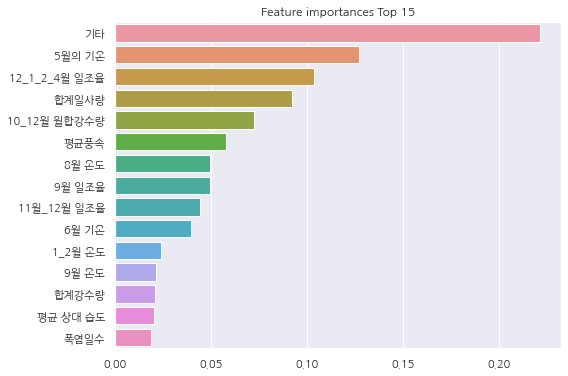

In [ ]:
ftr_importances_values = xgb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train_factor.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [ ]:
ftr_importances.sort_values(ascending=False)[:15]

기타               0.221402
5월의 기온           0.127161
12_1_2_4월 일조율    0.103615
합계일사량            0.092340
10_12월 월합강수량     0.072630
평균풍속             0.057784
8월 온도            0.049790
9월 일조율           0.049602
11월_12월 일조율      0.044499
6월 기온            0.039997
1_2월 온도          0.024166
9월 온도            0.021770
합계강수량            0.021266
평균 상대 습도         0.020527
폭염일수             0.018874
dtype: float32

---

## 2) RandomForest

- grid search

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier 모델 초기화
rf_model = RandomForestClassifier(random_state=42)

# 파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 150, 250],  # 트리의 개수
    'max_depth': [3, 5, 7],  # 트리의 최대 깊이
    'min_samples_split': [2, 3, 4],  # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 3, 4],  # 리프 노드의 최소 샘플 수
}

# 그리드 서치를 사용하여 최적의 파라미터 찾기
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_factor, y_train)

# 최적의 파라미터 출력
best_params = grid_search.best_params_
print("최적의 파라미터:", best_params)

최적의 파라미터: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


* 학습/예측/성능 평가

In [ ]:
# 최적의 파라미터로 모델 재초기화 및 학습
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train_factor, y_train)

# 모델을 사용하여 테스트 데이터 예측
y_pred2 = rf_model.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, y_pred2)

오차 행렬
[[  8   3  16   0]
 [  0  11  23   0]
 [  0   1 106   1]
 [  0   1  13  17]]
정확도: 0.7100, 정밀도: 0.7605, 재현율: 0.7100, F1:0.6744


* feature importance

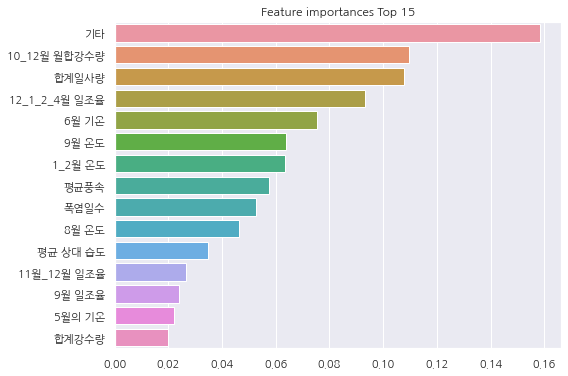

In [ ]:
ftr_importances_values = rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train_factor.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [ ]:
ftr_importances.sort_values(ascending=False)[:10]

기타               0.158251
10_12월 월합강수량     0.109715
합계일사량            0.107555
12_1_2_4월 일조율    0.093306
6월 기온            0.075289
9월 온도            0.063643
1_2월 온도          0.063436
평균풍속             0.057435
폭염일수             0.052459
8월 온도            0.046437
dtype: float64

---

## 3) SVM

- grid search + model fitting

In [ ]:
from sklearn.svm import SVC

# SVM 모델을 생성합니다.
svm = SVC()

# 튜닝할 하이퍼파라미터 그리드를 정의합니다.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'decision_function_shape': ['ovr', 'ovo'],
}

# 그리드 서치
grid_search3 = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search3.fit(X_train_factor, y_train)

# 최적의 하이퍼파라미터를 얻습니다.
best_params = grid_search3.best_params_
print('최적 하이퍼 파라미터:\n',grid_search3.best_params_)

최적의 k: 17


* 학습/예측/성능 평가

In [ ]:
# 최적의 파라미터로 모델 생성
best_svm = grid_search3.best_estimator_

# 모델 학습
best_svm.fit(X_train_factor, y_train)

# 검증 데이터 예측
y_pred3 = best_svm.predict(X_test_factor)

오차 행렬
[[11  7  9  0]
 [ 2 15 17  0]
 [ 4 10 93  1]
 [ 1  3 10 17]]
정확도: 0.6800, 정밀도: 0.6910, 재현율: 0.6800, F1:0.6713


In [ ]:
get_clf_eval(y_test, y_pred3)

---

## 4) GradientBoosting

- grid search

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting 분류기 초기화
gb_classifier = GradientBoostingClassifier(random_state=42)

# 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 7],
}

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_factor, y_train)

# 최적의 하이퍼파라미터를 출력
best_params = grid_search.best_params_
print("최적의 하이퍼 파라미터:", best_params)

최적의 하이퍼 파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


* 학습/예측/성능 평가

In [ ]:
# 최적 모델로 예측
best_gb_model = GradientBoostingClassifier(**best_params)
best_gb_model.fit(X_train_factor, y_train)

# 모델을 사용하여 테스트 데이터 예측
y_pred4 = best_gb_model.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, y_pred4)

오차 행렬
[[ 11   3  13   0]
 [  2  11  21   0]
 [  4   1 102   1]
 [  1   1  12  17]]
정확도: 0.7050, 정밀도: 0.7179, 재현율: 0.7050, F1:0.6787


* feature importance

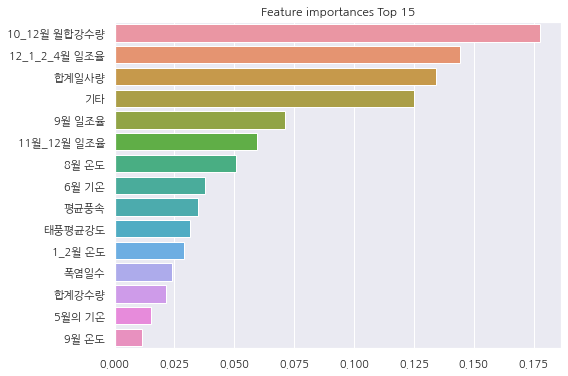

In [ ]:
ftr_importances_values = best_gb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train_factor.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [ ]:
ftr_importances.sort_values(ascending=False)[:10]

10_12월 월합강수량     0.177526
12_1_2_4월 일조율    0.144136
합계일사량            0.134282
기타               0.124988
9월 일조율           0.070985
11월_12월 일조율      0.059301
8월 온도            0.050619
6월 기온            0.037807
평균풍속             0.034681
태풍평균강도           0.031666
dtype: float64

---

## 5) AdaBoost

- grid search

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier  # 예시로 DecisionTreeClassifier를 사용합니다.

# AdaBoost 분류기 초기화
base_classifier = DecisionTreeClassifier(random_state=42)
ada_classifier = AdaBoostClassifier(base_estimator=base_classifier, random_state=42)

# 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'base_estimator__max_depth': [2, 3, 4, 5],  # DecisionTreeClassifier의 max_depth 조정
}

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=ada_classifier, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_factor, y_train)

# 최적의 하이퍼파라미터를 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

최적 하이퍼파라미터: {'base_estimator__max_depth': 4, 'learning_rate': 0.01, 'n_estimators': 300}


* 학습/예측/성능 평가

In [ ]:
# 최적 모델로 예측
best_ada_classifier = grid_search.best_estimator_
y_pred5 = best_ada_classifier.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, y_pred5)

오차 행렬
[[ 11   3  13   0]
 [  2  11  21   0]
 [  4   1 103   0]
 [  1   1  20   9]]
정확도: 0.6700, 정밀도: 0.7086, 재현율: 0.6700, F1:0.6303


* feature importance

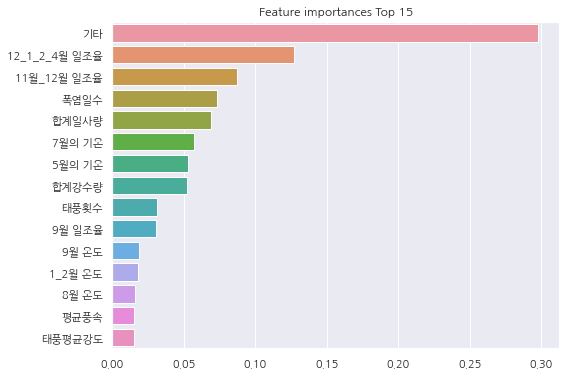

In [ ]:
ftr_importances_values = best_ada_classifier.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train_factor.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [ ]:
ftr_importances.sort_values(ascending=False)[:10]

기타               0.297282
12_1_2_4월 일조율    0.127098
11월_12월 일조율      0.086844
폭염일수             0.072842
합계일사량            0.069089
7월의 기온           0.057311
5월의 기온           0.052893
합계강수량            0.052133
태풍횟수             0.031228
9월 일조율           0.030524
dtype: float64

---

## 6) 앙상블

In [ ]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier

# Voting Classifier를 사용하여 앙상블 생성
# 이 예에서는 하드 보팅(각 모델의 예측 결과를 다수결로 선택)을 사용합니다.
voting_classifier = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('ada', best_ada_classifier)],
    voting='hard'
    )

# Voting Classifier 학습
voting_classifier.fit(X_train_factor, y_train)

# 각 모델의 예측을 얻을 수 있습니다.
xgb_predictions = xgb_model.predict(X_test_factor)
rf_predictions = rf_model.predict(X_test_factor)
ada_predictions = best_ada_classifier.predict(X_test_factor)
voting_predictions = voting_classifier.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, voting_predictions)

오차 행렬
[[ 11   3  13   0]
 [  2  11  21   0]
 [  4   1 103   0]
 [  1   1  20   9]]
정확도: 0.6700, 정밀도: 0.7086, 재현율: 0.6700, F1:0.6303


In [ ]:
# 스태킹 앙상블

from sklearn.ensemble import StackingClassifier

# 스태킹 앙상블 생성
stacking_models = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('ada', best_ada_classifier)
]

stacking_classifier = StackingClassifier(
    estimators=stacking_models
    )

# 스태킹 앙상블 모델 훈련
stacking_classifier.fit(X_train_factor, y_train)

# 테스트 데이터에 대한 예측
stacking_predictions = stacking_classifier.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, stacking_predictions)

오차 행렬
[[  9   3  15   0]
 [  2  11  21   0]
 [  2   1 104   1]
 [  1   1  12  17]]
정확도: 0.7050, 정밀도: 0.7195, 재현율: 0.7050, F1:0.6736


---

# **10. 결론**
- 기상 데이터의 요인 분석을 통해 새로운 변수를 만들고, 태풍, 폭염일수, 장마의 데이터를 통해 5가지의 학습기를 만들어 예측하였다.
- 최종 모델 : xgboost

In [ ]:
# # 튜닝하지 않은 xgboost 의 F1 score가 가장 높기 때문에 모델 저장
# 해당 데이터는 제출했으므로 주석처리
# import pickle

# with open('red_xgb_model.pkl', 'wb') as model_file:
#     pickle.dump(xgb_model, model_file)

---

# **11. 사과 품질에 영향을 미치는 요인 분석**

* 최종 모델 xgboost의 feature 변수를 분석하여 사과 품질에 영향을 미치는 기상 요인을 알아보았다.

## 1) feature importance

머신러닝 모델에서 각 피처(변수)가 예측 결과에 얼마나 큰 영향을 미치는지를 나타내는 지표

* 이를 이용하면 모델이 어떤 피처를 주로 활용하여 예측을 수행하는지 파악할 수 있음.
* 중요한 피처들은 모델의 예측에 큰 영향을 미치는 요소로 간주됨

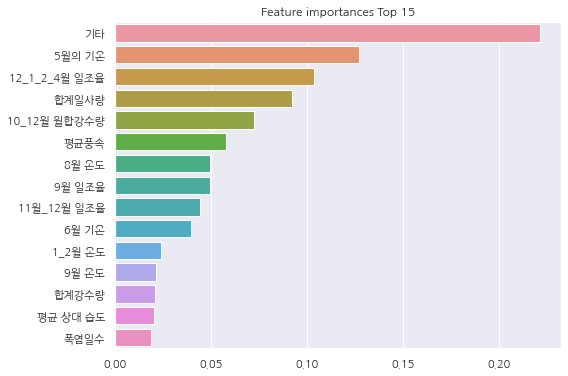

In [ ]:
plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지
ftr_importances_values = xgb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train_factor.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

## 2) SAHP(SHapley Additive exPlanation)
모델의 예측을 해석하는데 사용하기 위해 제안된 방법

#### (1) SAHP(SHapley Additive exPlanation) 개념

* SHAP은 Shapley value를 이용하여 예측에 대해 각 feature의 기여도를 계산하는 기법
* Shapley value는 게임 이론에 기반을 두고 있으며, 이는 feature의 모든 combination에 대해 feature의 기여도를 계산하여 그 값을 평균낸 값이다.


- 하지만, feature의 개수가 늘어날수록 전체 Shapley value를 연산하는데 들어가는 비용이 매우 커지게 된다. 이런 높은 연산 비용을 극복하기 위해 원래 모델의 conditional expectation의 Shapley value를 계산한다


#### (2) SHAP과 feature importance 비교

[feature importance]

permutation 기법을 사용하여 피쳐가 모델에 미치는 영향을 측정한다.

* 장점
    * 측정이 쉬우며 알고리즘이 단순하다.
* 단점
    * 피쳐간의 상호 연관성이 높을 경우 결과가 편향될 수 있다.
    * 음의 영향력은 계산하지 않는다.


[SHAP]

Shapley value를 사용하여 피쳐가 모델에 미치는 영향을 측정한다.

* 장점
    * 피쳐간의 의존성을 고려
    * 음의 영향력을 고려하여, feature importance가 보장하지 못하는 넓은 범위의 함정을 피할 수 있다.

* 단점
    * 기본 계산량이 많아 측정 속도가 느림
    * 기본 계산량을 줄이면 오차 분산이 커져 신뢰도가 떨어진다.

#### (3) SHAP 분석

* shap value 구하기

In [ ]:
# shap_values 구하기
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_factor)

* 전체 class의 Summary Plot

    Summary Plot은 각 클래스에 feature 변수가 미치는 영향을 누적으로 표현한 feature importance plot이다.

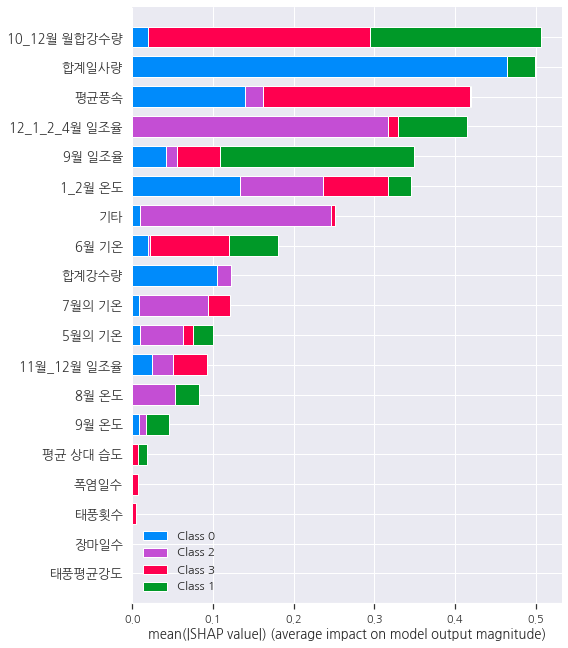

In [ ]:
shap.summary_plot(shap_values, X_test_factor)

1. 전체적으로 보았을 때, 평균 풍속과 9월 일조율 변수가 미치는 영향이 가장 크다. 다음으로는 12~4월 일조율, 11월_12월 일조율이다.

    =>  2번째에서 4번째까지 변수가 모두 일조율인 것을 보아, 사과에 영향을 미치는 주된 기상요인이 일조율임을 알 수 있다.

2. 태풍 횟수와 장마일수는 영향을 적게준다.

3. feature importance와 비교해봤을 때, 영향을 주는 변수의 순서가 크게 다른 것을 확인할 수 있고 이는 변수간의 의존성을 고려했기 때문으로 보인다.

* 특정 class의 summary_plot

    * summary plot의 각 점은 Shapley value이다. 이때,가장 덜 중요한 feature 변수는 값이 0에 가깝다.


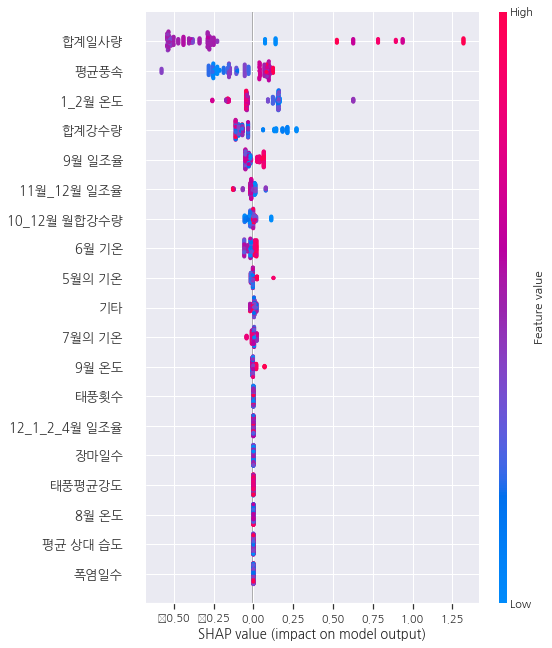

In [ ]:
shap.summary_plot(shap_values[0], X_test_factor, title="Class 0 Summary Plot")

1. class0으로 예측할 때(1등급으로 예측할 때), 평균 풍속과 합계 일사량, 태풍 평균 강도에는 크게 영향을 받음을 알 수 있다. 이는 평균 풍속과 합계 일사량, 태풍 평균 강도가 1등급 사과를 결정하는데 주된 요인임을 의미한다.

2. 평균 풍속 변수를 보면 대부분의 shaply value가 양의 값을 가지고 있다. 이는 이 변수는 양의 영향력을 가진 변수임을 의미한다. 반대로 합계 일사량 변수를 보면 대부분이 음수의 값을 가진다. 이는 이 변수가 음의 영향력을 가진 변수임을 의미한다.

2. 6월의 기온, 평균 상대 습도, 9월의 온도, 태풍 횟수는 1등급 품질의 사과에 거의 영향을 주지 않는다.


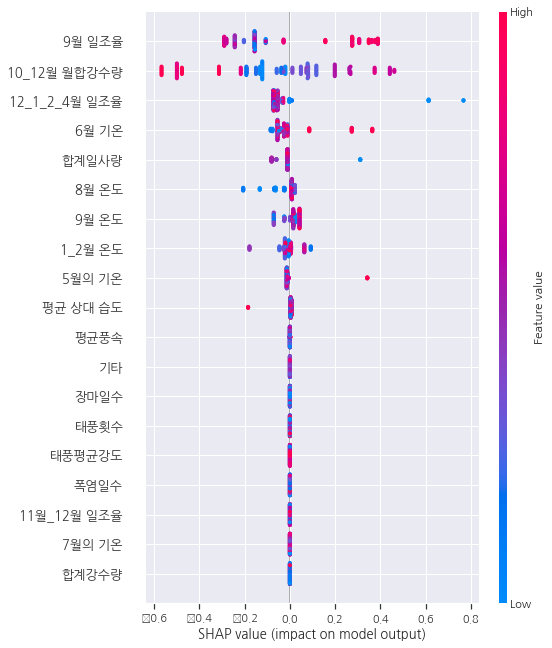

In [ ]:
shap.summary_plot(shap_values[1], X_test_factor, title="Class 1 Summary Plot")

1. class1으로 예측할 때(2등급으로 예측할 때), 9월 일조율, 평균 풍속, 평균 상대 습도,12_1_2_4월 일조율, 11_12월 일조율에 영향을 많이 받는다. 이를 통해 2등급으로 예측할 때는 일조율이 중요한 요인임을 알 수 있다.  



2. 합계 일사량, 기타, 8월 온도, 태풍 평균 강도, 합계 강수량에는 거의 영향을 받지 않는다.



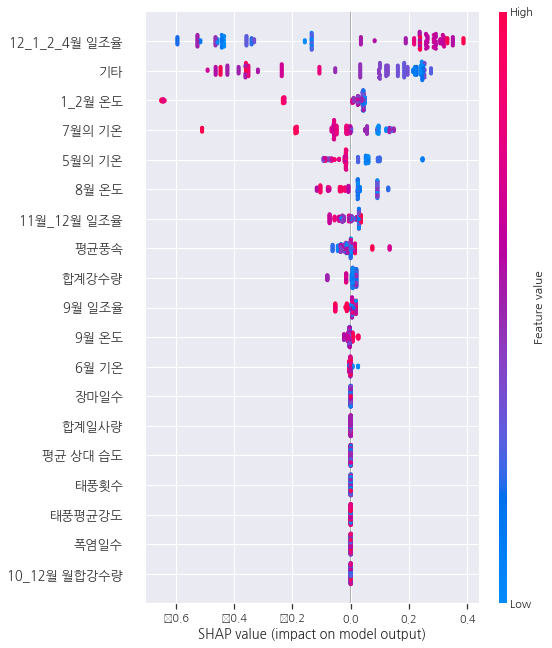

In [ ]:
shap.summary_plot(shap_values[2], X_test_factor, title="Class 2 Summary Plot")

1. class2로 예측할 때(3등급으로 예측할 때),  기타, 12_1_2_4월 일조율, 8월 온도에 크게 영향을 받음을 알 수 있다.

2. 다른 클래스와는 다르게 평균 풍속, 9월 일조율, 10_12월 월합 강수량에는 거의 영향을 받지 않는다.

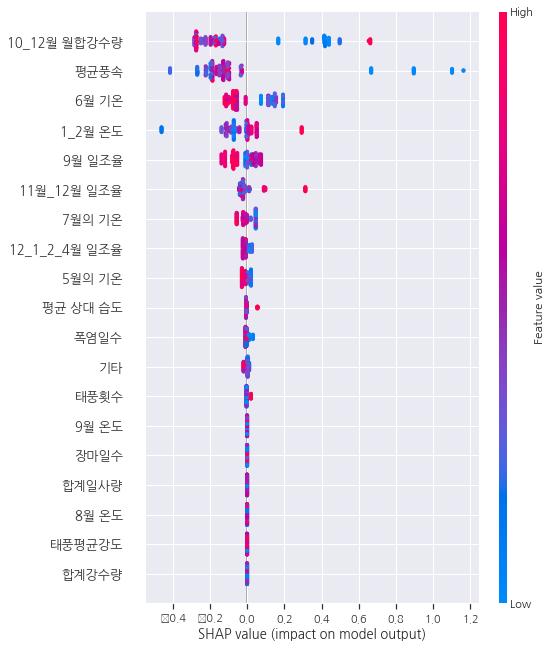

In [ ]:
shap.summary_plot(shap_values[3], X_test_factor, title="Class 3 Summary Plot")

1. class3으로 예측할 때(4등급으로 예측할 때), 9월 일조율, 평균 풍속, 1_2월 온도, 10_12월 월합 강수량에는 크게 영향을 받는다.

2. 10_1_2_4월 일조율, 기타, 8월 온도, 합계 일사량에는 거의 영향을 받지 않는다.

3. class2와 class3은 예측에 영향을 주는 기상 요인이 반대로 나타남을 확인할 수 있다. 평균 풍속, 9월 일조율, 10_12월 월합 강수량은 class2를 예측하는데 영향을 주지 않았지만, class3으로 예측하는데는 큰 영향을 미쳤다.